**CNN - Salmon Classification**

In [1]:
!pip install torch torchvision lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 47.7 MB/s eta 0:00:00


# Dataset

In [2]:
train_path = '/content/drive/MyDrive/salmon_dataSet/train'
test_path = '/content/drive/MyDrive/salmon_dataSet/test'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import shutil
import glob
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [5]:
train_path = '/content/drive/MyDrive/salmon_dataSet/train'
test_path = '/content/drive/MyDrive/salmon_dataSet/test'
new_path = '/content/drive/MyDrive/salmon_organized'

In [6]:
ext = ["png", "jpg", "jpeg", "gif"]

train_files = []
test_files = []

for e in ext:
    train_files += glob.glob(os.path.join(train_path, f"*.{e}"))
    test_files += glob.glob(os.path.join(test_path, f"*.{e}"))

print(f'train: {len(train_files)}, test: {len(test_files)}')

train: 353, test: 80


In [7]:
def get_label(path):
    name = os.path.basename(path).lower()
    if 'wild' in name:
        return 'wild'
    else:
        return 'farmed'

train_labels = [get_label(f) for f in train_files]

In [8]:
for split in ['train', 'val', 'test']:
    for label in ['wild', 'farmed']:
        os.makedirs(f'{new_path}/{split}/{label}', exist_ok=True)

In [9]:
train_files, val_files, train_y, val_y = train_test_split(
    train_files, train_labels,
    test_size=0.2,
    random_state=42,
    stratify=train_labels
)

# Move train files
for file, label in zip(train_files, train_y):
    dest = f'{new_path}/train/{label}/{os.path.basename(file)}'
    shutil.copy2(file, dest)

# Move val files
for file, label in zip(val_files, val_y):
    dest = f'{new_path}/val/{label}/{os.path.basename(file)}'
    shutil.copy2(file, dest)

# Move test files
for file in test_files:
    label = get_label(file)
    dest = f'{new_path}/test/{label}/{os.path.basename(file)}'
    shutil.copy2(file, dest)

print(f'train: {len(train_files)}, val: {len(val_files)}, test: {len(test_files)}')


train: 282, val: 71, test: 80


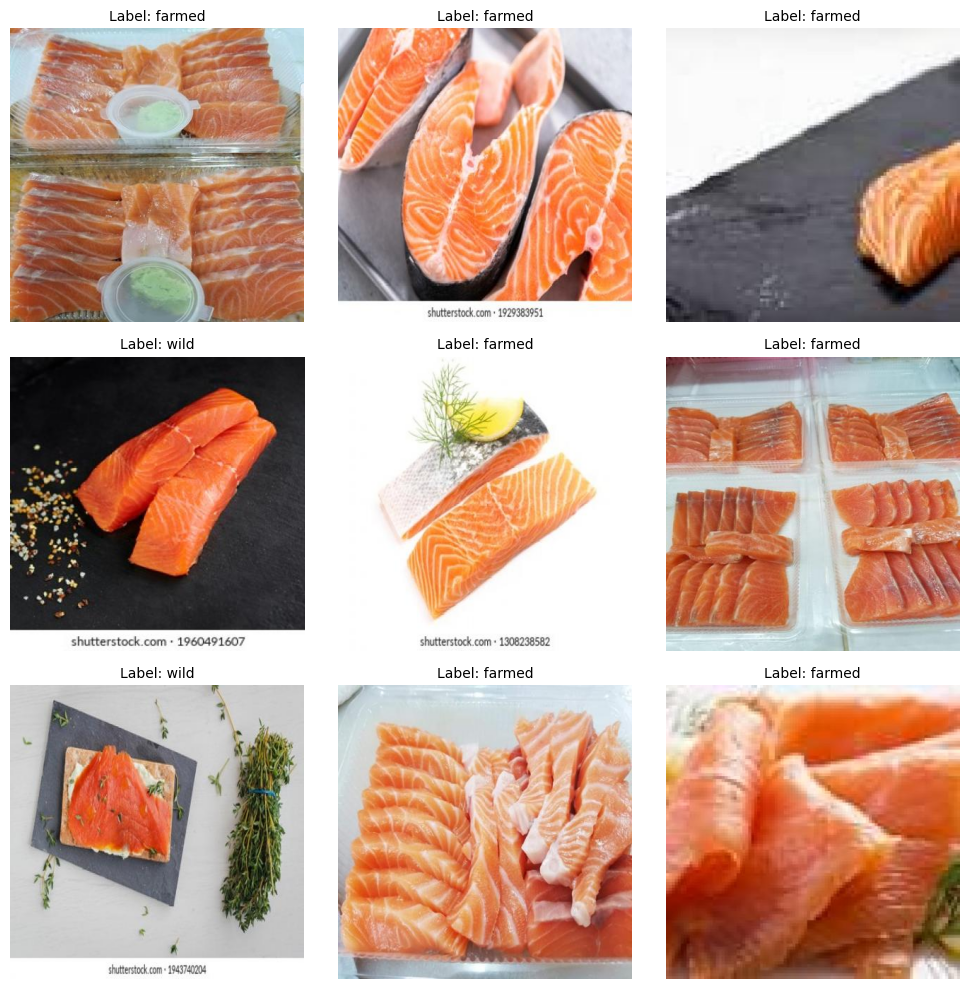

In [10]:
import cv2 as cv
import matplotlib.pyplot as plt
import random

num_images = 3*3

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

max_len = len(train_files)
indices = random.sample(range(max_len), num_images)

for i, idx in enumerate(indices):
    image_path = train_files[idx]

    label = train_y[idx]

    img = cv.imread(image_path)

    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    axes[i].imshow(img_rgb)
    axes[i].set_title(f"Label: {label}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [11]:
class ImageFolderDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=64, image_size=224, num_workers=2):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_workers = num_workers

        self.train_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)
            )
        ])

        self.val_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)
            )
        ])

    def setup(self, stage=None):
        self.train_dataset = datasets.ImageFolder(
            root=f"{self.data_dir}/train",
            transform=self.train_transform
        )
        self.val_dataset = datasets.ImageFolder(
            root=f"{self.data_dir}/val",
            transform=self.val_transform
        )
        self.num_classes = len(self.train_dataset.classes)
        self.class_names = self.train_dataset.classes

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

In [12]:
dm = ImageFolderDataModule(data_dir=new_path, batch_size=64, image_size=224)
dm.setup()

print(f'classes: {dm.class_names}')
print(f'num_classes: {dm.num_classes}')

classes: ['farmed', 'wild']
num_classes: 2


In [13]:
train_loader = dm.train_dataloader()
xb, yb = next(iter(train_loader))
print(f'xb shape: {xb.shape}')
print(f'yb shape: {yb.shape}')
print(f'labels: {yb[:10]}')

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


xb shape: torch.Size([64, 3, 224, 224])
yb shape: torch.Size([64])
labels: tensor([1, 1, 1, 0, 0, 1, 1, 0, 1, 1])


# Simple CNN

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics

In [15]:
class SimpleCNN(pl.LightningModule):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 56 * 56, num_classes)

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = torch.flatten(x, start_dim=1)

        x = self.fc1(x)
        return x

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        preds = torch.argmax(outputs, dim=1)
        acc = self.accuracy(preds, labels)

        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        self.log("train_acc", acc, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        preds = torch.argmax(outputs, dim=1)
        acc = self.accuracy(preds, labels)

        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        self.log("val_acc", acc, prog_bar=True, on_epoch=True)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

In [16]:
model = SimpleCNN(num_classes=dm.num_classes)

trainer = pl.Trainer(max_epochs=7, accelerator='auto', devices=1)

trainer.fit(model, dm)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ conv1    │ Conv2d             │    896 │ train │     0 │
│ 1 │ conv2    │ Conv2d             │ 18.5 K │ train │     0 │
│ 2 │ relu     │ ReLU               │      0 │ train │     0 │
│ 3 │ pool     │ MaxPool2d          │      0 │ train │     0 │
│ 4 │ fc1      │ Linear             │  401 K │ train │     0 │
│ 5 │ accuracy │ MulticlassAccuracy │      0 │ train │     0 │
└───┴──────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 420 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 420 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 6                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:317: The number of training batches (5)
is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you 
want to see logs for the training epoch.

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.


In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

test_dataset = datasets.ImageFolder(
    root=f"{new_path}/test",
    transform=dm.val_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

model.eval()

y_true = []
y_pred = []

total = 0
correct = 0

print("Starting prediction")
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Prediction complete\n")

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

Starting prediction
Prediction complete

Accuracy: 77.50%


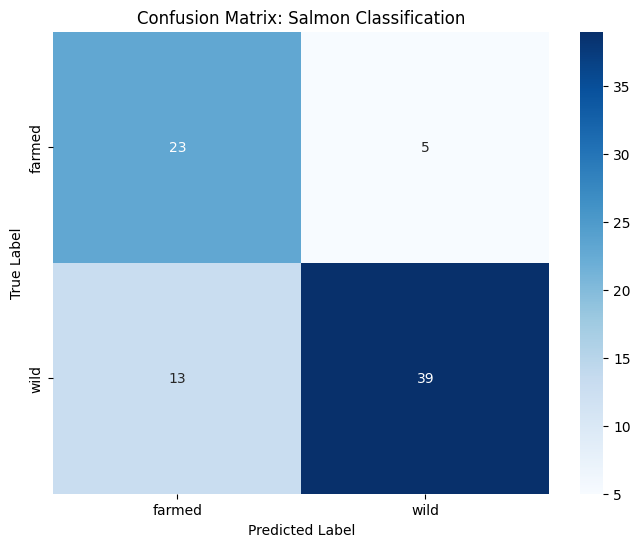

In [18]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=dm.class_names,
    yticklabels=dm.class_names
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Salmon Classification')
plt.show()

# EfficientNet-B0

In [25]:
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class SalmonDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=32, num_workers=2):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.num_classes = 2

    def setup(self, stage=None):
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        self.train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

        self.test_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

        self.train_dataset = datasets.ImageFolder(root=f"{self.data_dir}/train", transform=self.train_transform)
        self.val_dataset = datasets.ImageFolder(root=f"{self.data_dir}/val", transform=self.test_transform)
        self.test_dataset = datasets.ImageFolder(root=f"{self.data_dir}/test", transform=self.test_transform)

        print(f"Classes: {self.train_dataset.classes}")

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

In [26]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torchmetrics

class SalmonEfficientNet(pl.LightningModule):
    def __init__(self, num_classes=2, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters()

        # 1. โหลด EfficientNet-B0 (Pre-trained)
        self.model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

        # 2. แก้ไข Classifier Head ให้เหลือ 2 Classes
        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_features, num_classes)
        )

        # 3. Metrics (วัดผล)
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)
        acc = self.accuracy(outputs.argmax(dim=1), labels)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)
        acc = self.accuracy(outputs.argmax(dim=1), labels)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)
        acc = self.accuracy(outputs.argmax(dim=1), labels)
        self.log("test_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        # ใช้ LR ต่ำๆ และมีตัวปรับลด LR ถ้านิ่ง
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.1, patience=3
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss"
            }
        }

In [28]:
dm = SalmonDataModule(data_dir=new_path, batch_size=32)

model = SalmonEfficientNet(num_classes=2, learning_rate=1e-4)

trainer = pl.Trainer(
    max_epochs=7,
    accelerator='auto',
    devices=1,
    logger=True
)

trainer.fit(model, dm)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Classes: ['farmed', 'wild']


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model    │ EfficientNet       │  4.0 M │ train │     0 │
│ 1 │ accuracy │ MulticlassAccuracy │      0 │ train │     0 │
│ 2 │ loss_fn  │ CrossEntropyLoss   │      0 │ train │     0 │
└───┴──────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 4.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.0 M                                                                                                
Total estimated model params size (MB): 16                                                                         
Modules in train mode: 341                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:317: The number of training batches (9)
is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you 
want to see logs for the training epoch.

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.


In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score

trainer.test(model, dm)

model.eval()

all_preds = []
all_labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

test_loader = dm.test_dataloader()

print("Starting prediction")
for images, labels in test_loader:
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("Prediction complete\n")

acc = accuracy_score(all_labels, all_preds)

print(f"Test Accuracy: {acc * 100:.2f}%")

Classes: ['farmed', 'wild']


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │          0.9375           │
└───────────────────────────┴───────────────────────────┘

Starting prediction
Prediction complete

Test Accuracy: 93.75%


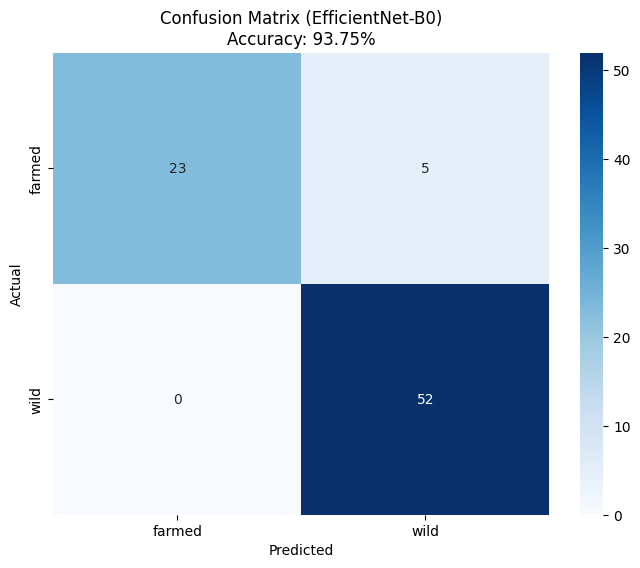

In [34]:
cm = confusion_matrix(all_labels, all_preds)
class_names = dm.test_dataset.classes

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (EfficientNet-B0)\nAccuracy: {acc*100:.2f}%')
plt.show()